## 비모수 분석 종합 템플릿 (All-in-One)

이 노트북은 `nonparametric_analysis` 패키지가 제공하는 **17종의 모든 분석 기능**을 예시와 함께 제공합니다.
각 결과 아래에는 **통계 비전문가를 위한 '결과 해석 가이드'**가 포함되어 있습니다.


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import warnings

# Jupyter용 matplotlib 설정
%matplotlib inline

# 경고 무시
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Add src to path
sys.path.append(str(Path('../03_Code/src').resolve()))

import matplotlib.pyplot as plt
from nonparametric_analysis.analysis import nonparametric_methods as np_methods
from nonparametric_analysis.analysis import utils
from nonparametric_analysis.analysis.visualizations import setup_visualization

setup_visualization() # 한글 폰트 및 스타일 설정

def show_result(res):
    """분석 결과를 보기 좋게 출력하는 헬퍼 함수"""
    print("=" * 55)
    print("  분석 결과 요약")
    print("=" * 55)
    for k, v in res.items():
        if k == 'figure':
            continue
        if isinstance(v, pd.DataFrame):
            print(f"\n  [{k}]")
            display(v)
        elif isinstance(v, float):
            print(f"  {k:.<30s} {v:.4f}")
        else:
            print(f"  {k:.<30s} {v}")
    print("=" * 55)
    plt.show()

In [2]:
# 데이터 로드
data_path = Path('../02_Data/sample_nonparametric.csv')
df = pd.read_csv(data_path)
series = df['feature_1'].dropna()

# 그룹 분할 (예시: feature_2 기준 50 초과/이하)
group_a = df[df['feature_2'] > 50]['feature_1']
group_b = df[df['feature_2'] <= 50]['feature_1']

# 짝지어진 데이터 예시 (Paired)
before = series[:30].values
after = before + np.random.normal(0.5, 1, 30) # 약간의 변화 추가

# 3개 그룹 데이터 예시 (Repeated / Multi)
t1 = series[:30].values
t2 = series[30:60].values
t3 = series[60:90].values

print(f'Data Loaded: Series N={len(series)}, Group A={len(group_a)}, Group B={len(group_b)}')

Data Loaded: Series N=118, Group A=59, Group B=59


### 1. 단일 변수 분석 (Single Variable)


#### 1.1 정규성 검정 (Normality Test)


  분석 결과 요약
  statistic..................... 0.8922
  p_value....................... 0.0000
  is_normal..................... False


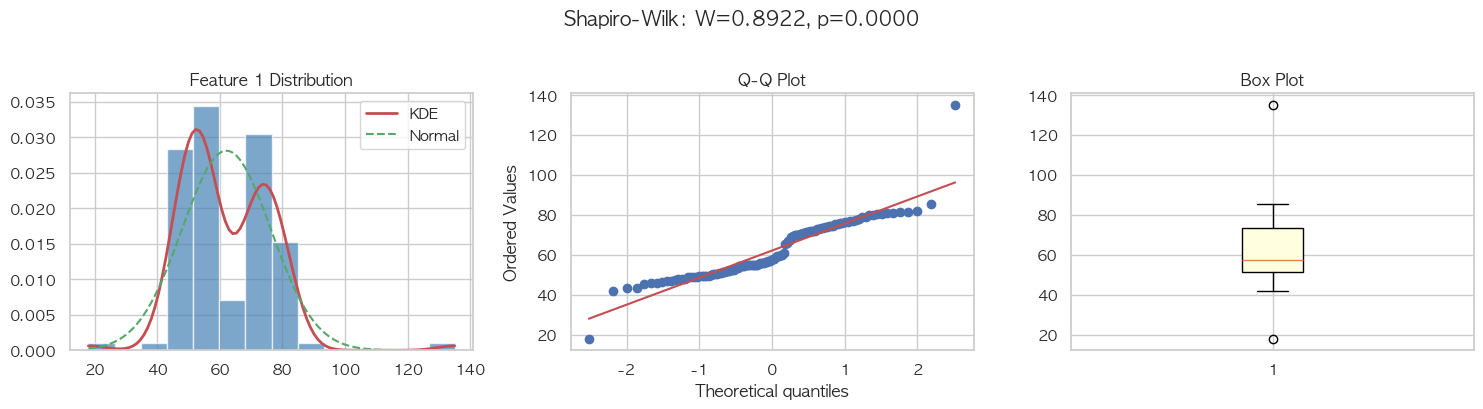

In [3]:
res = np_methods.test_normality(series, name="Feature 1")
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 데이터가 "종 모양(정규분포)"인지 확인합니다.

**📊 결과 읽는 법**:
- **Is Normal = True** → 데이터가 정규분포입니다
  - → t-검정, ANOVA 같은 **모수 검정 사용 가능**
- **Is Normal = False** → 데이터가 치우쳐 있습니다
  - → Mann-Whitney, Kruskal-Wallis 같은 **비모수 검정 사용** (현재 분석들!)

**💼 실무 활용**:
- 예: 고객 만족도 데이터 → Is Normal = False
  - 판단: "소수의 매우 불만족 고객이 평균을 왜곡. 중앙값과 비모수 분석 사용"
- 예: 제품 품질 측정값 → Is Normal = True
  - 판단: "정규분포 → 일반적인 통계 분석 가능"

**📈 차트 확인**:
- **히스토그램**: 종 모양이면 정규분포
- **Q-Q Plot**: 점들이 직선을 따라가면 정규분포
- **Box Plot**: 상자가 대칭이면 정규분포 가능성 높음

#### 1.2 런 검정 (Runs Test - 무작위성)


  분석 결과 요약
  runs.......................... 8
  expected...................... 60.0000
  z............................. -9.6152
  p_value....................... 0.0000


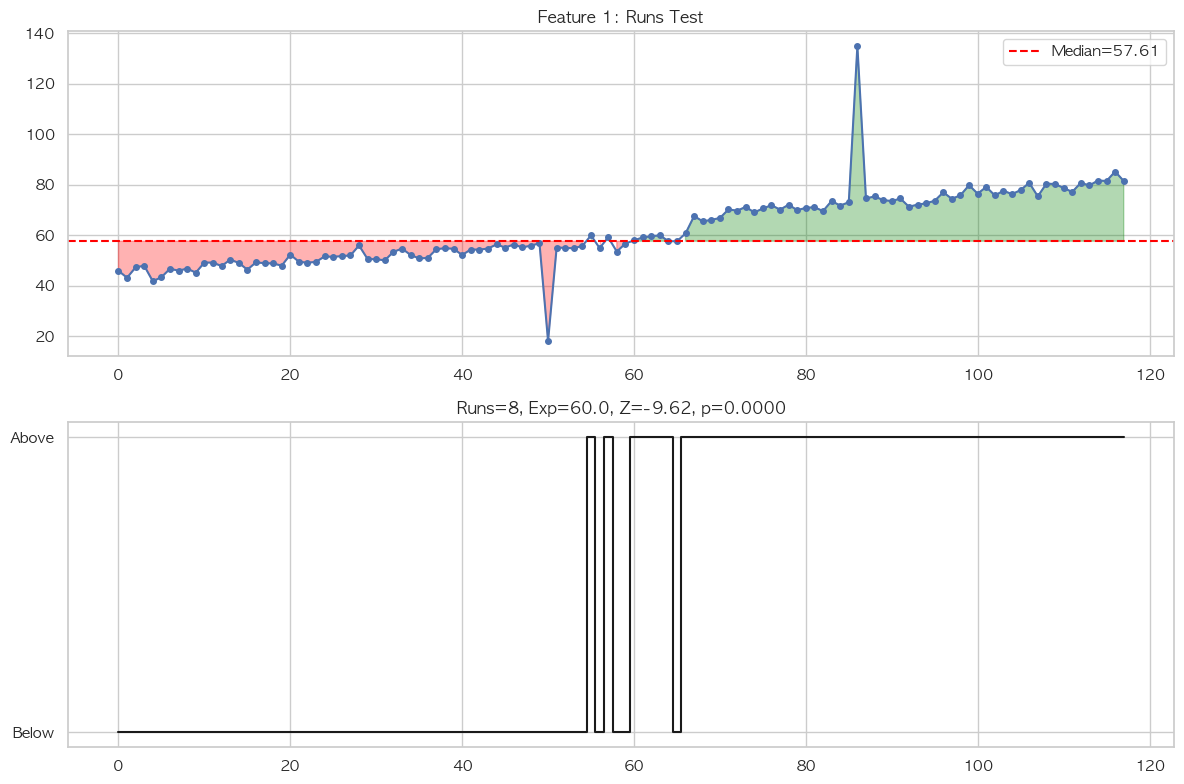

In [4]:
res = np_methods.runs_test_analysis(series, name="Feature 1")
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 데이터가 **완전히 무작위**로 나타났는지, 아니면 **어떤 패턴**이 숨어있는지 확인합니다.

**📊 결과 읽는 법**:
- **p ≥ 0.05** → 무작위입니다 (Random)
  - → 데이터에 규칙적인 패턴이 없음
  - → 예측 불가능한 자연스러운 변동
- **p < 0.05** → 무작위가 아닙니다 (Not Random)
  - → 데이터에 **숨겨진 패턴**이 존재함
  - → 주기성, 추세, 또는 체계적인 변화 가능성

**💼 실무 활용**:
- 예: 주식 가격 데이터 → p < 0.05
  - 판단: "무작위가 아님. 특정 시점에 집중적인 상승/하락 패턴 존재. 원인 조사 필요"
- 예: 품질 불량률 → p = 0.001
  - 판단: "무작위가 아님. 특정 시간대/작업자에게 불량이 몰림. 공정 점검 필요"
- 예: 고객 방문 시간 → p = 0.82
  - 판단: "무작위 분포. 고객 방문에 특별한 패턴 없음. 상시 인력 배치 유지"

**📈 차트 확인**:
- **런 플롯**: 파란 선(실제 런)이 빨간 선(기대값) 근처면 무작위
- **플러스/마이너스 마커**: 고르게 섞여 있으면 무작위
- **연속된 같은 부호**: 길게 이어지면 패턴 존재

#### 1.3 추세 분석 (Mann-Kendall Trend)


  분석 결과 요약
  tau........................... 0.8693
  p_value....................... 0.0000
  slope......................... 0.3355
  trend......................... increasing


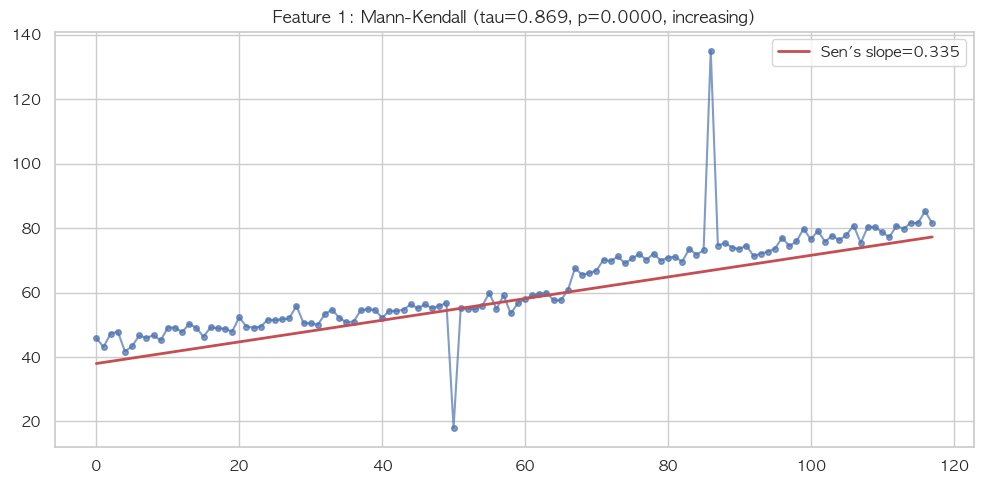

In [5]:
res = np_methods.mann_kendall_test(series, name="Feature 1")
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 시간에 따라 데이터가 **꾸준히 증가/감소**하는지 확인합니다.

**📊 결과 읽는 법**:
- **Trend = 'increasing'** → 지속적인 상승 추세
  - → Slope > 0: 시간당/단위당 얼마나 증가하는지
  - → p < 0.05: 우연이 아닌 진짜 증가 추세
- **Trend = 'decreasing'** → 지속적인 하락 추세
  - → Slope < 0: 시간당/단위당 얼마나 감소하는지
  - → p < 0.05: 우연이 아닌 진짜 감소 추세
- **Trend = 'no trend'** → 추세 없음
  - → p ≥ 0.05: 일시적 변동일 뿐, 장기 추세 없음

**💼 실무 활용**:
- 예: 월별 매출 데이터 → Trend='increasing', Slope=50, p=0.002
  - 판단: "매월 평균 50만원씩 증가 중. 통계적으로 유의한 성장세. 확장 투자 검토"
- 예: 고객 이탈률 → Trend='decreasing', Slope=-0.5%, p=0.01
  - 판단: "매월 0.5%씩 이탈률 감소. 개선 정책이 효과적. 현 전략 유지"
- 예: 품질 점수 → Trend='no trend', p=0.45
  - 판단: "일관된 추세 없음. 일시적 변동. 구조적 개선 필요 없음"

**📈 차트 확인**:
- **추세선**: 우상향이면 증가, 우하향이면 감소
- **Slope 값**: 기울기가 클수록 빠른 변화
- **신뢰구간**: 좁을수록 추세가 명확함

#### 1.4 변곡점 탐지 (Pettitt Test)


  분석 결과 요약
  change_point.................. 60
  statistic..................... 3462.0000
  p_value....................... 0.0000
  median_before................. 51.4875
  median_after.................. 73.5300


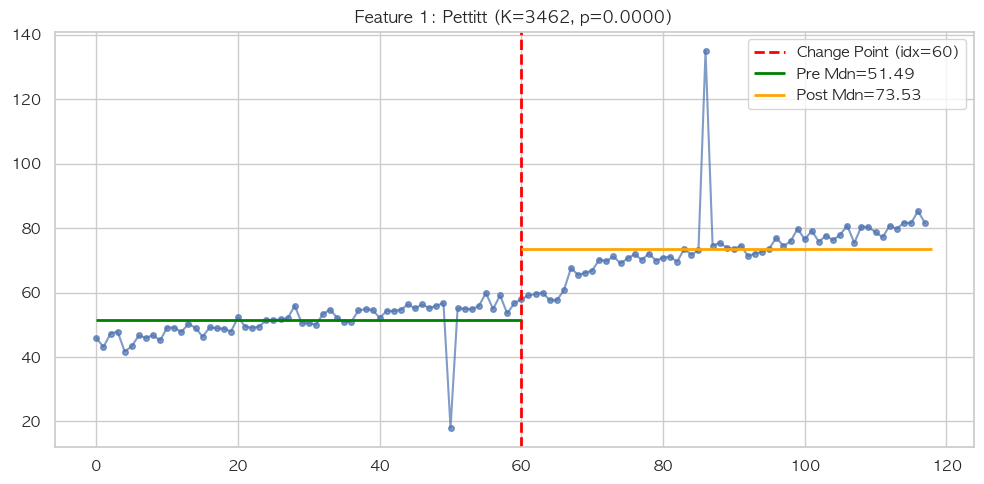

In [6]:
res = np_methods.pettitt_test(series, name="Feature 1")
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 데이터의 평균 수준이 **갑자기 바뀐 특정 시점**을 찾습니다.

**📊 결과 읽는 법**:
- **Change Point = 숫자** → 변화가 일어난 데이터 위치
  - → 예: Change Point = 60 → 60번째 데이터를 전후로 급변
  - → p < 0.05: 우연이 아닌 진짜 구조적 변화
- **Change Point = None** → 변곡점 없음
  - → p ≥ 0.05: 일관된 패턴 유지, 급격한 변화 없음

**💼 실무 활용**:
- 예: 일별 방문자 수 → Change Point = 45일차, p = 0.003
  - 판단: "45일차부터 방문자 수 급증. 해당 시점 마케팅 캠페인 확인. 성공 요인 분석"
- 예: 제품 불량률 → Change Point = 120번째, p = 0.001
  - 판단: "120번째 제품부터 불량률 급증. 해당 시점 설비/원자재 변경 조사 필요"
- 예: 주간 매출 → Change Point = None, p = 0.67
  - 판단: "뚜렷한 변곡점 없음. 매출이 일관되게 유지됨. 현상 유지 전략"

**📈 차트 확인**:
- **빨간 수직선**: 변화가 일어난 시점 표시
- **선 좌우 패턴**: 명확히 다른 수준이면 변화 확실
- **Before/After 평균**: 두 구간의 평균 차이 확인

#### 1.5 다중 구간 분할 (PELT)


  분석 결과 요약
  changepoints.................. []
  n_segments.................... 1


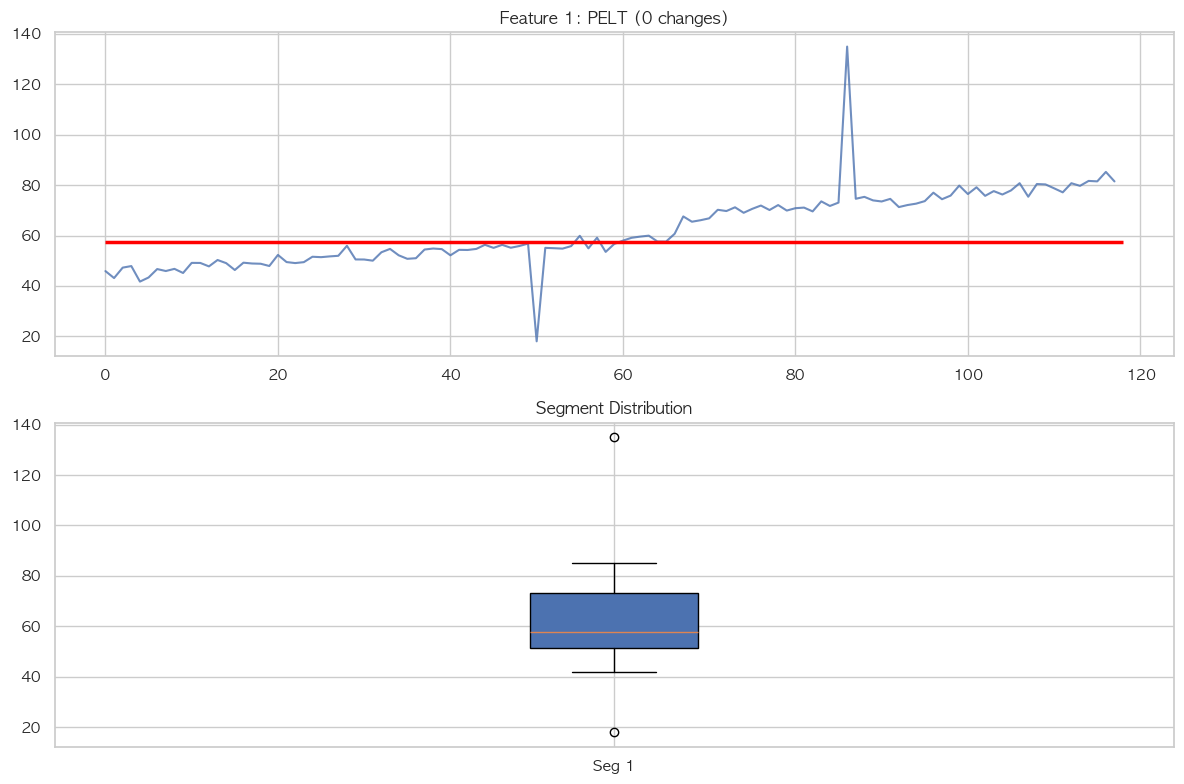

In [7]:
res = np_methods.detect_changepoints_pelt(series, name="Feature 1")
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 데이터의 패턴이 바뀌는 **여러 지점을 동시에** 모두 찾습니다.

**📊 결과 읽는 법**:
- **Change Points = [10, 35, 78]** → 3개의 변화 지점 발견
  - → 데이터가 4개 구간으로 나뉨 (1~10, 11~35, 36~78, 79~끝)
  - → 각 구간마다 다른 특성(평균, 분산 등)을 가짐
- **Change Points = []** → 변화 지점 없음
  - → 데이터가 처음부터 끝까지 일관된 패턴 유지

**💼 실무 활용**:
- 예: 시간대별 서버 부하 → Change Points = [8, 12, 18, 22]
  - 판단: "출근(8시), 점심(12시), 퇴근(18시), 심야(22시)에 패턴 변화. 각 시간대별 리소스 할당 필요"
- 예: 분기별 매출 → Change Points = [90, 180]
  - 판단: "90일, 180일차에 매출 패턴 변화. 해당 시점 프로모션/계절성 분석"
- 예: 제품 품질 → Change Points = [150]
  - 판단: "150번째 제품부터 품질 변화. 공정 변경 또는 원자재 변경 시점 확인"

**📈 차트 확인**:
- **빨간 수직선들**: 각 변화 지점 표시
- **구간별 색상**: 다른 색상으로 구분된 구간들
- **각 구간의 평균선**: 구간마다 다른 수준

### 2. 그룹 비교 (Group Comparison)


#### 2.1 두 독립 그룹 비교 (Mann-Whitney U)


  분석 결과 요약
  statistic..................... 3303.0000
  z............................. 8.9547
  p_value....................... 0.0000
  r............................. 0.8314
  cles.......................... 0.9822
  cliffs_delta.................. 0.9643


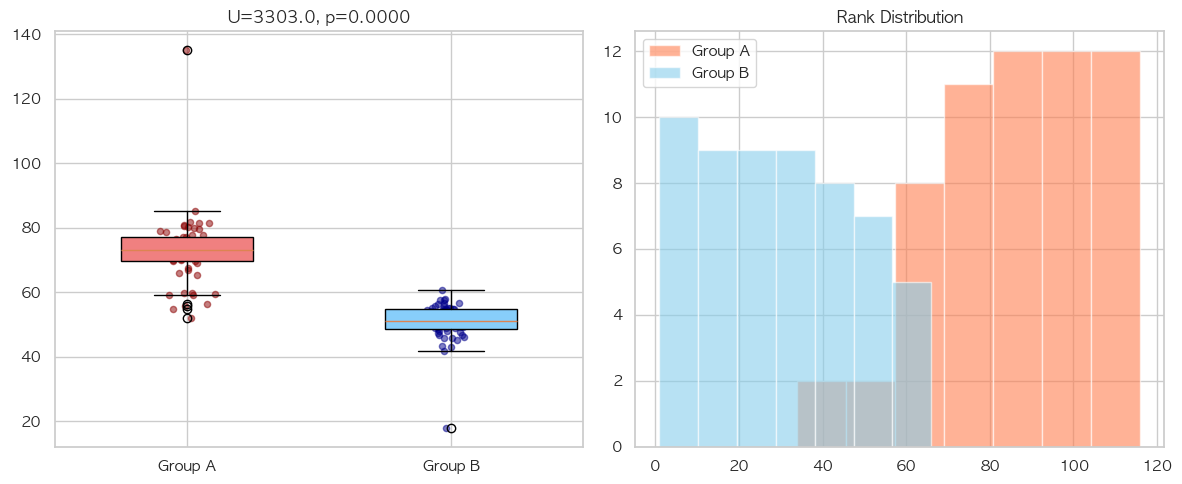

In [8]:
res = np_methods.mann_whitney_test(group_a, group_b, name1="Group A", name2="Group B")
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 서로 다른 **두 그룹(A vs B)**의 중앙값이 다른지 비교합니다.

**📊 결과 읽는 법**:
- **p < 0.05** → 두 그룹은 통계적으로 **차이가 있습니다**
  - → Effect Size가 크면 클수록 차이가 명확함
  - → A 그룹과 B 그룹을 다르게 취급해야 함
- **p ≥ 0.05** → 두 그룹은 통계적으로 **차이가 없습니다**
  - → 두 그룹을 구분할 필요 없음
  - → 같은 모집단으로 간주 가능

**💼 실무 활용**:
- 예: 신약 vs 위약 → p = 0.003, Effect Size = 0.65 (큰 효과)
  - 판단: "신약이 위약보다 명확히 효과적. 치료 효과 입증됨. 승인 신청 가능"
- 예: 남성 vs 여성 만족도 → p = 0.02, Effect Size = 0.12 (작은 효과)
  - 판단: "통계적으로 유의하나 실질적 차이는 미미함. 성별 맞춤 전략 불필요"
- 예: 오전 vs 오후 생산량 → p = 0.45
  - 판단: "시간대별 차이 없음. 교대 근무 시 고려 불필요"

**📈 차트 확인**:
- **Box Plot**: 상자가 겹치지 않으면 차이가 큼
- **중앙값 선**: 두 그룹의 중앙값 위치 비교
- **분포 범위**: 상자와 수염의 위치로 전체 분포 비교

#### 2.2 두 분포 비교 (K-S Test)


  분석 결과 요약
  statistic..................... 0.9147
  p_value....................... 0.0000


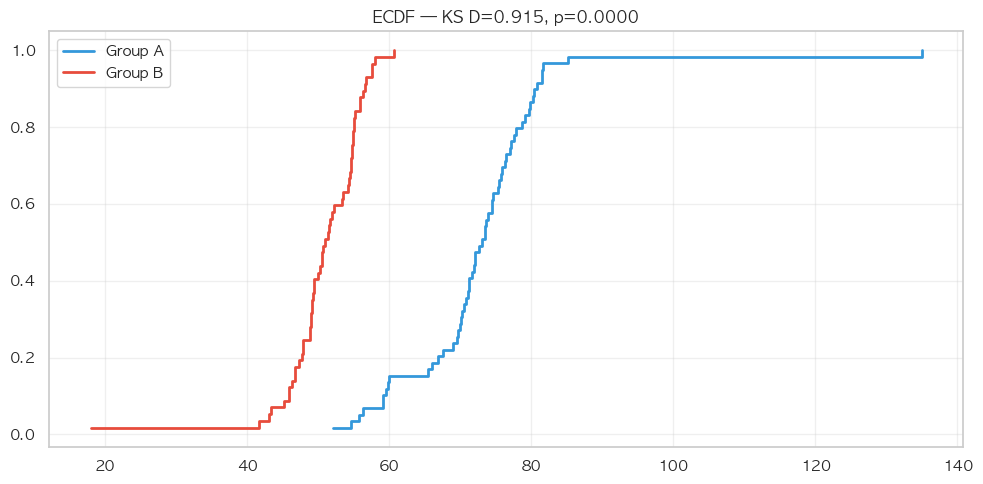

In [9]:
res = np_methods.ks_test(group_a, group_b, name1="Group A", name2="Group B")
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 두 데이터의 **분포 모양 전체**가 같은지 다른지 확인합니다.

**📊 결과 읽는 법**:
- **p < 0.05** → 두 분포가 **서로 다릅니다**
  - → 중앙값뿐 아니라 퍼진 정도, 모양도 다름
  - → 완전히 다른 특성을 가진 그룹
- **p ≥ 0.05** → 두 분포가 **같습니다**
  - → 중앙값, 퍼진 정도, 모양 모두 유사
  - → 같은 방식으로 생성된 데이터

**💬 Mann-Whitney와의 차이**:
- **Mann-Whitney**: 중앙값(위치)만 비교
- **K-S Test**: 중앙값 + 퍼진 정도 + 모양까지 모두 비교

**💼 실무 활용**:
- 예: A 공장 vs B 공장 제품 무게 → p = 0.001
  - 판단: "두 공장의 생산 방식이 완전히 다름. 표준화 필요. 품질 관리 재점검"
- 예: 기존 고객 vs 신규 고객 구매액 → p = 0.03
  - 판단: "구매 패턴 자체가 다름. 신규/기존 고객 맞춤 전략 필요"
- 예: 남부 vs 북부 지역 온도 → p = 0.56
  - 판단: "온도 분포 유사. 지역 구분 없이 동일 제품 판매 가능"

**📈 차트 확인**:
- **누적 분포 곡선**: 두 선이 멀리 떨어져 있으면 분포가 다름
- **최대 거리(D)**: D 값이 클수록 분포 차이가 큼
- **히스토그램 겹침**: 두 히스토그램이 완전히 다른 모양이면 분포 다름

#### 2.3 짝지어진 그룹 비교 (Wilcoxon Signed Rank)


  분석 결과 요약
  statistic..................... 103.0000
  z............................. -2.6636
  p_value....................... 0.0066
  r............................. 0.4863
  median_diff................... 0.4850


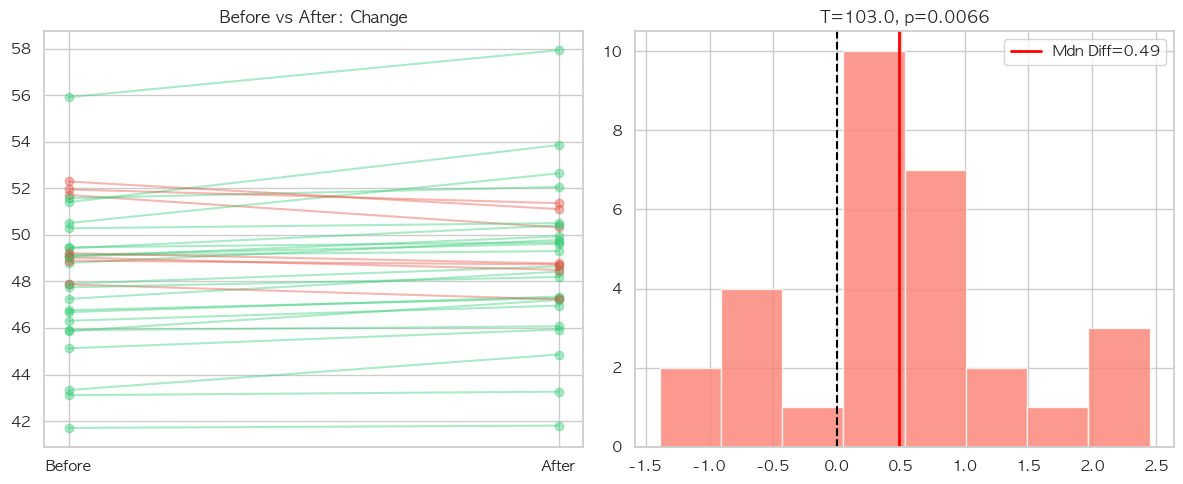

In [10]:
res = np_methods.wilcoxon_paired_test(before, after, name="Before vs After")
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: **전/후(Before/After)** 같이 짝을 이룬 데이터의 변화를 확인합니다.

**📊 결과 읽는 법**:
- **p < 0.05** → 전후에 **유의미한 변화**가 있었습니다
  - → Effect Size가 크면 클수록 변화가 크고 명확함
  - → 개입(치료, 교육, 정책 등)이 효과가 있었음
- **p ≥ 0.05** → 전후에 **유의미한 변화가 없습니다**
  - → 개입의 효과가 없거나 미미함
  - → 다른 접근 방법 필요

**💬 사용 조건**:
- **반드시 동일 대상**의 전/후 측정이어야 함
- 예: 동일 환자의 치료 전/후, 동일 학생의 교육 전/후

**💼 실무 활용**:
- 예: 다이어트 프로그램 전/후 체중 → p = 0.001, Effect Size = 0.72
  - 판단: "프로그램이 체중 감소에 명확한 효과. 상용화 가능. 마케팅 포인트로 활용"
- 예: 교육 전/후 시험 점수 → p = 0.03, Effect Size = 0.15
  - 판단: "통계적으로 유의하나 실질적 향상 미미. 교육 방법 개선 필요"
- 예: 정책 시행 전/후 만족도 → p = 0.34
  - 판단: "정책 효과 없음. 다른 정책 시도 또는 보완책 마련 필요"

**📈 차트 확인**:
- **전/후 Box Plot**: 두 상자의 위치가 명확히 다르면 변화가 큼
- **개별 변화선**: 대부분의 선이 한 방향으로 향하면 일관된 변화
- **중앙값 이동**: 중앙값 선이 크게 움직였는지 확인

#### 2.4 부호 검정 (Sign Test)


  분석 결과 요약
  n_pos......................... 7
  n_neg......................... 23
  p_value....................... 0.0052


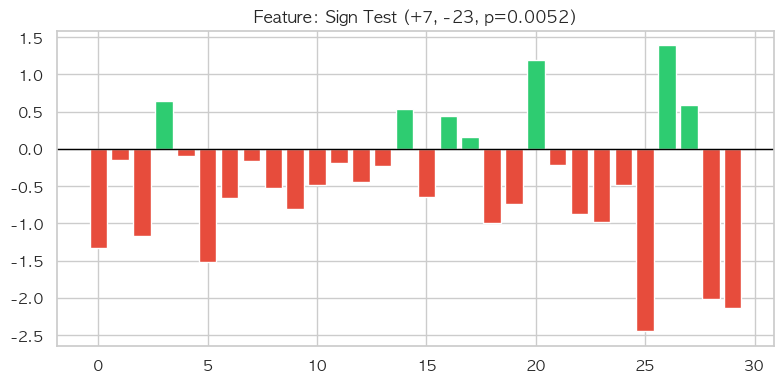

In [11]:
res = np_methods.sign_test(before, after)
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 변화의 크기는 무시하고 **증가/감소 방향**만 확인합니다.

**📊 결과 읽는 법**:
- **p < 0.05** → 한쪽 방향(증가 또는 감소)이 **압도적**입니다
  - → 대부분이 증가했거나, 대부분이 감소했음
  - → 방향성이 명확한 변화
- **p ≥ 0.05** → 증가와 감소가 **비슷**합니다
  - → 어떤 사람은 증가, 어떤 사람은 감소
  - → 일관된 방향성 없음

**💬 Wilcoxon과의 차이**:
- **Wilcoxon**: 변화의 크기를 고려 (10 증가 > 1 증가)
- **Sign Test**: 변화의 방향만 고려 (10 증가 = 1 증가 = 그냥 '증가')

**💼 실무 활용**:
- 예: 광고 캠페인 전/후 인지도 → p = 0.001, 증가 90%, 감소 10%
  - 판단: "대다수가 인지도 향상. 캠페인 성공. 추가 투자 가치 있음"
- 예: 신제품 출시 전/후 고객 만족도 → p = 0.45, 증가 55%, 감소 45%
  - 판단: "증가/감소 혼재. 일관된 반응 없음. 타겟 고객 재정의 필요"
- 예: 시스템 업데이트 후 응답속도 → p = 0.002, 증가 5%, 감소 95%
  - 판단: "대부분 느려짐. 업데이트 롤백 또는 긴급 패치 필요"

**📈 차트 확인**:
- **+/- 막대**: 증가(+)와 감소(-)의 개수 비교
- **비율 표시**: 증가 비율이 압도적이면 효과 있음
- **개별 변화 점**: 대부분이 한쪽으로 쏠리는지 확인

#### 2.5 세 독립 그룹 비교 (Kruskal-Wallis)


  분석 결과 요약
  statistic..................... 72.0062
  p_value....................... 0.0000
  eta_squared................... 0.8047

  [dunn_posthoc]


,G1,G2,G3
G1,1.000000e+00,0.000595,7.680152e-17
G2,5.951376e-04,1.000000,6.286301e-06
G3,7.680152e-17,0.000006,1.000000e+00


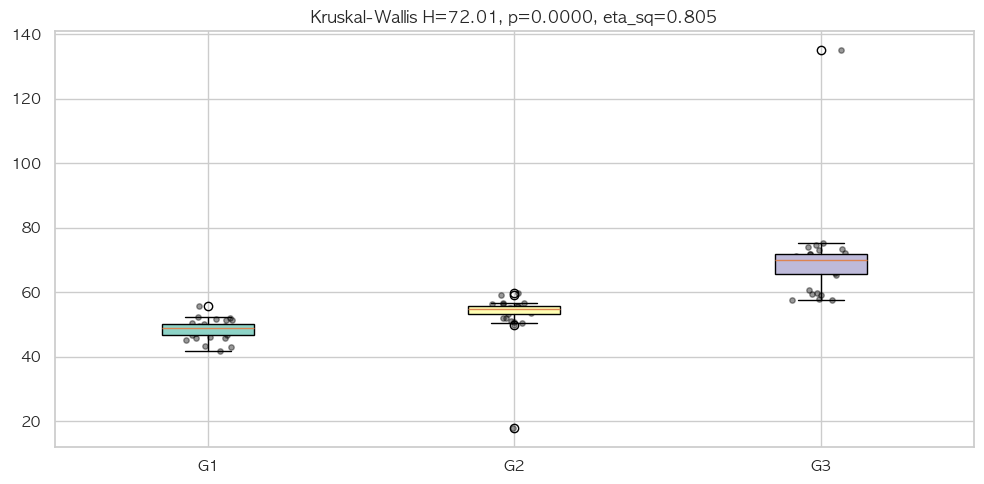

In [12]:
res = np_methods.kruskal_wallis_test([t1, t2, t3], group_names=["G1", "G2", "G3"])
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 3개 이상의 독립된 그룹 중 **적어도 하나는 다른지** 확인합니다.

**📊 결과 읽는 법**:
- **p < 0.05** → 그룹 간에 **차이가 존재**합니다
  - → 적어도 한 그룹이 다른 그룹들과 다름
  - → 어느 그룹이 다른지는 추가 분석(사후검정) 필요
- **p ≥ 0.05** → 모든 그룹이 **차이가 없습니다**
  - → 그룹을 구분할 필요 없음
  - → 하나의 동일한 모집단으로 취급 가능

**💬 사용 조건**:
- **서로 다른** 독립된 그룹이어야 함 (A그룹, B그룹, C그룹)
- 같은 대상의 반복 측정은 Friedman Test 사용

**💼 실무 활용**:
- 예: A/B/C 세 광고의 클릭률 → p = 0.002
  - 판단: "광고 간 차이 있음. 사후검정으로 어느 광고가 최고인지 확인 후 집중 투자"
- 예: 아침/점심/저녁 시간대 매출 → p = 0.001
  - 판단: "시간대별 매출 차이 있음. 각 시간대별 맞춤 메뉴/프로모션 필요"
- 예: 지역별(서울/부산/대구) 만족도 → p = 0.52
  - 판단: "지역 간 차이 없음. 전국 통일 정책 적용 가능"

**📈 차트 확인**:
- **Box Plot**: 상자들이 겹치지 않으면 차이가 큼
- **중앙값 위치**: 한 그룹의 중앙값이 다른 그룹들과 명확히 다른지
- **분포 범위**: 어느 그룹이 가장 높은지/낮은지 시각적으로 확인

#### 2.6 반복 측정 비교 (Friedman Test)


  분석 결과 요약
  statistic..................... 56.2667
  p_value....................... 0.0000
  kendall_w..................... 0.9378


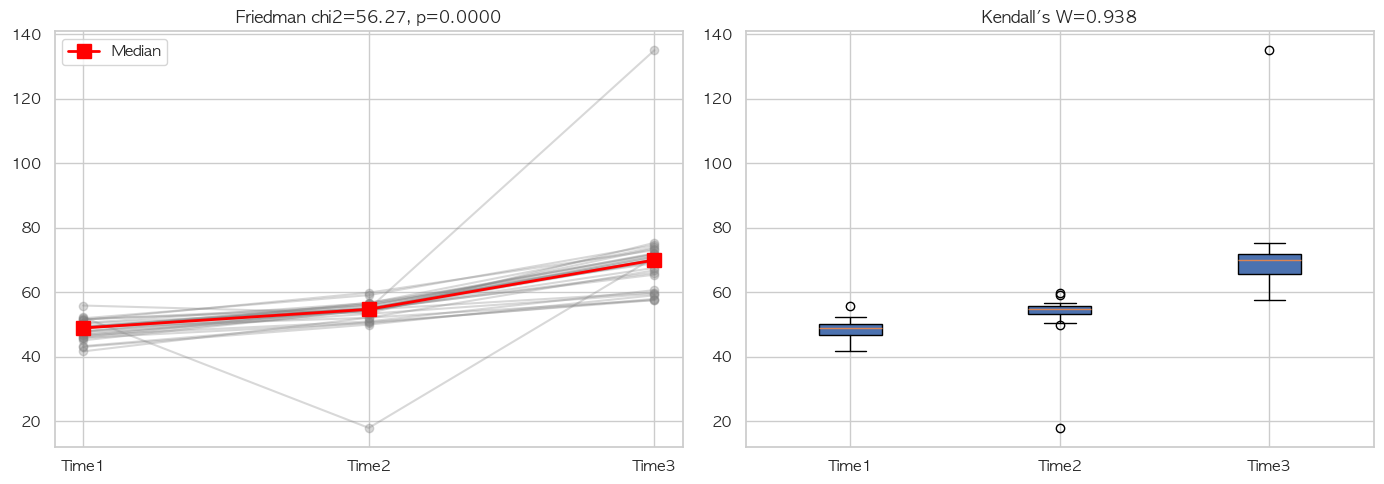

In [13]:
# 데이터 길이 맞춤 (필수)
data_matrix = [t1, t2, t3]
res = np_methods.friedman_test(data_matrix, condition_names=["Time1", "Time2", "Time3"])
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 3개 이상의 시점/조건에서 **동일한 대상**을 반복 측정했을 때 차이를 확인합니다.

**📊 결과 읽는 법**:
- **p < 0.05** → 시점/조건 간에 **차이가 존재**합니다
  - → 적어도 한 시점이 다른 시점들과 다름
  - → 시간에 따른 변화 또는 조건 효과가 있음
- **p ≥ 0.05** → 시점/조건 간에 **차이가 없습니다**
  - → 시간이 지나도 변화 없음
  - → 조건을 바꿔도 효과 없음

**💬 사용 조건**:
- **반드시 동일 대상**의 반복 측정이어야 함
- 예: 같은 환자를 1개월, 3개월, 6개월 후 측정

**💼 실무 활용**:
- 예: 다이어트 프로그램 (시작/1개월/3개월/6개월) → p = 0.001
  - 판단: "시간에 따라 체중 변화 있음. 사후검정으로 어느 시점에 가장 효과적인지 파악"
- 예: 약물 용량 (저용량/중용량/고용량) 동일 환자 → p = 0.03
  - 판단: "용량에 따라 효과 차이 있음. 최적 용량 찾기 위한 추가 분석 필요"
- 예: 계절별(봄/여름/가을/겨울) 동일 매장 매출 → p = 0.67
  - 판단: "계절 영향 없음. 연중 일관된 마케팅 전략 유지"

**📈 차트 확인**:
- **시점별 Box Plot**: 시점에 따라 상자 위치가 바뀌는지 확인
- **평균 순위**: 어느 시점의 순위가 가장 높은지/낮은지
- **변화 추세선**: 시간 흐름에 따른 패턴 확인

### 3. 상관 관계 (Correlation)


#### 3.1 상관 행렬 (Heatmap)


  분석 결과 요약

  [correlation]


,time_index,feature_1,feature_2,feature_3,feature_total
time_index,1.000000,0.970961,0.936350,0.867381,0.964933
feature_1,0.970961,1.000000,0.944113,0.846329,0.975298
feature_2,0.936350,0.944113,1.000000,0.827346,0.980586
feature_3,0.867381,0.846329,0.827346,1.000000,0.850504
feature_total,0.964933,0.975298,0.980586,0.850504,1.000000



  [p_values]


,time_index,feature_1,feature_2,feature_3,feature_total
time_index,0.000000e+00,6.696936e-74,1.452533e-54,1.452562e-37,2.170987e-70
feature_1,6.696936e-74,0.000000e+00,8.934848e-57,1.614457e-33,6.383471e-78
feature_2,1.452533e-54,8.934848e-57,0.000000e+00,7.785470e-31,6.341828e-84
feature_3,1.452562e-37,1.614457e-33,7.785470e-31,0.000000e+00,1.017100e-34
feature_total,2.170987e-70,6.383471e-78,6.341828e-84,1.017100e-34,0.000000e+00


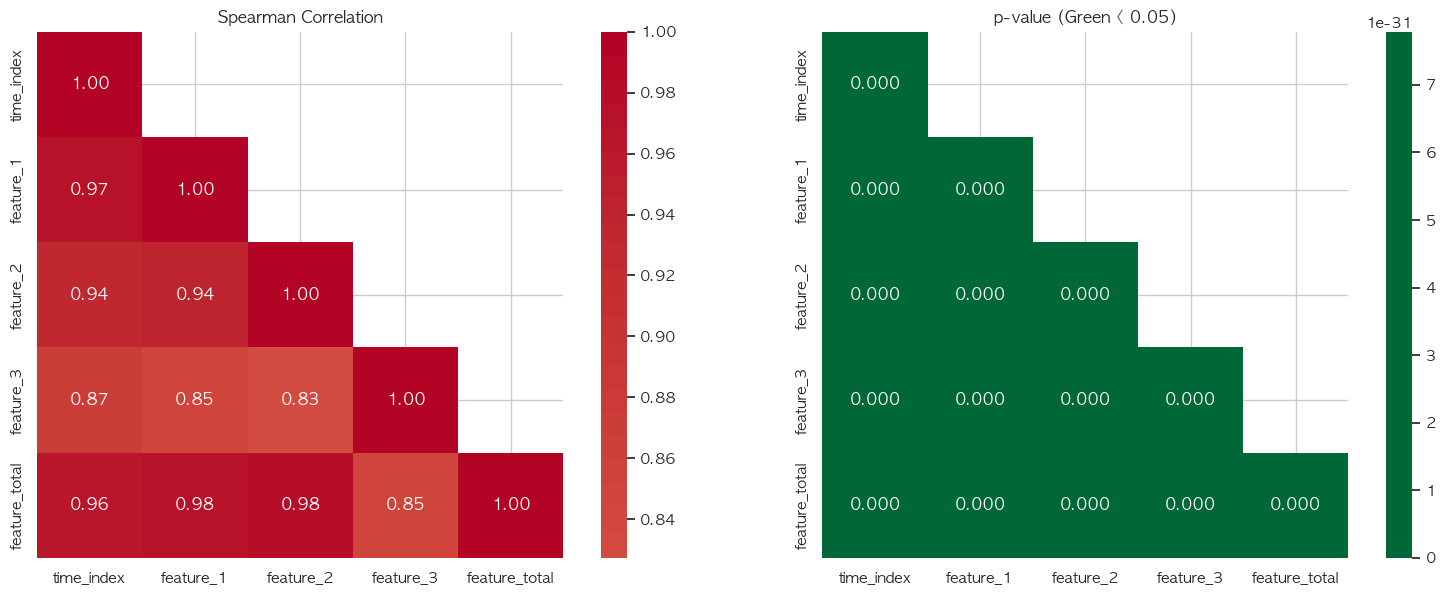

In [14]:
res = np_methods.correlation_matrix_nonparametric(df)
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 여러 변수들 간의 **관계를 한눈에** 확인합니다.

**📊 결과 읽는 법**:
- **상관계수 (숫자)**:
  - **+1에 가까움**: 매우 강한 양의 관계 (함께 증가)
  - **0에 가까움**: 관계 없음 (독립적)
  - **-1에 가까움**: 매우 강한 음의 관계 (하나 증가하면 하나 감소)
- **색상**:
  - **초록색**: 양의 관계 (함께 움직임)
  - **빨간색**: 음의 관계 (반대로 움직임)
  - **흰색/회색**: 관계 없음

**💼 실무 활용**:
- 예: 마케팅비 vs 매출 → 상관계수 = 0.85, p < 0.001
  - 판단: "마케팅비 증가 시 매출 크게 증가. 광고 투자 확대 정당화"
- 예: 가격 vs 판매량 → 상관계수 = -0.72, p < 0.001
  - 판단: "가격 올리면 판매량 감소. 가격 인상 시 매출 감소 위험 고려 필요"
- 예: 직원만족도 vs 생산성 → 상관계수 = 0.15, p = 0.32
  - 판단: "관계 미약. 만족도 높인다고 생산성 향상 보장 안됨. 다른 요인 탐색"

**📈 차트 확인**:
- **히트맵**: 진한 초록/빨강일수록 강한 관계
- **대각선**: 자기 자신과의 상관은 항상 1.0
- **대칭성**: 좌상단과 우하단이 대칭 (A-B = B-A)
- **클러스터**: 비슷한 색상끼리 모여 있으면 관련 변수 그룹

#### 3.2 다양한 상관 분석 (Kendall, Distance)


Kendall Tau: 0.5763, p-value: 0.0000


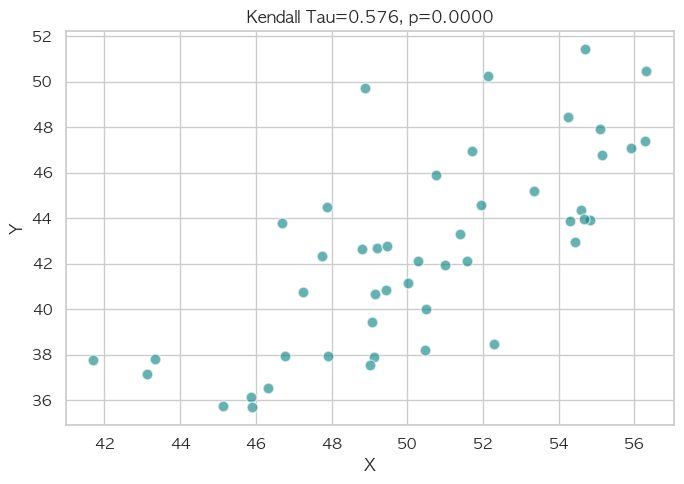

Distance Corr: 0.7187, p-value: 0.0000


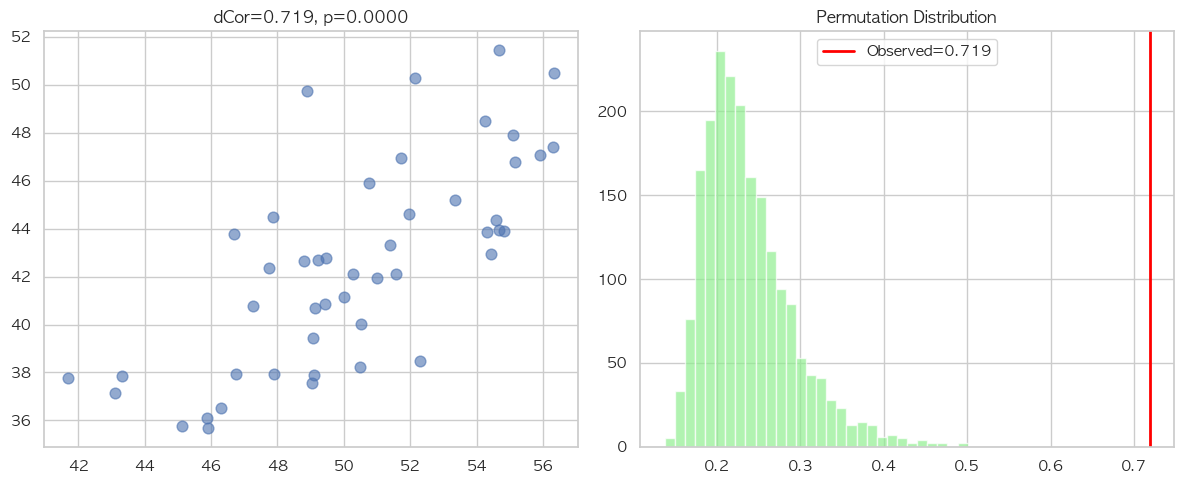

In [15]:
x = df['feature_1'][:50]
y = df['feature_2'][:50]

res_k = np_methods.kendall_corr(x, y)
print(f"Kendall Tau: {res_k['correlation']:.4f}, p-value: {res_k['p_value']:.4f}")
plt.show()

res_d = np_methods.distance_correlation(x, y)
print(f"Distance Corr: {res_d['dcor']:.4f}, p-value: {res_d['p_value']:.4f}")
plt.show()

##### 💡 결과 해석

**📊 Kendall Tau (켄달 타우)**:
- **목적**: 순위 동점이 많을 때 더 정확한 상관 분석
- **값 해석**:
  - **+1에 가까움**: 강한 양의 관계
  - **0에 가까움**: 관계 없음
  - **-1에 가까움**: 강한 음의 관계
- **Spearman과의 차이**: 동일 값(동점)이 많을 때 더 안정적

**📊 Distance Correlation (거리 상관)**:
- **목적**: **곡선 관계(비선형)**도 찾아냅니다
- **값 해석**:
  - **0**: 완전히 독립적 (관계 없음)
  - **1**: 완전히 종속적 (강한 관계)
  - 중요: 항상 0~1 사이 값 (음수 없음)
- **일반 상관과의 차이**: 
  - 일반 상관: 직선 관계만 찾음 (y = ax + b)
  - Distance: 곡선 관계도 찾음 (y = x², y = sin(x) 등)

**💼 실무 활용**:
- 예: Kendall Tau = 0.75 vs Spearman = 0.68 (동점 많은 데이터)
  - 판단: "Kendall이 더 신뢰할 만함. Spearman은 동점에 취약"
- 예: 일반 상관 = 0.1, Distance 상관 = 0.8
  - 판단: "직선 관계는 약하지만 곡선 관계는 강함. 비선형 모델 고려 필요"
- 예: Distance 상관 = 0.05
  - 판단: "직선이든 곡선이든 관계 없음. 두 변수 독립적"

### 4. 리샘플링 기법 (Resampling)


#### 4.1 부트스트랩 신뢰구간 (Bootstrap CI)


  분석 결과 요약
  observed...................... 62.0852
  ci_lower...................... 59.5622
  ci_upper...................... 64.6571
  se............................ 1.3331


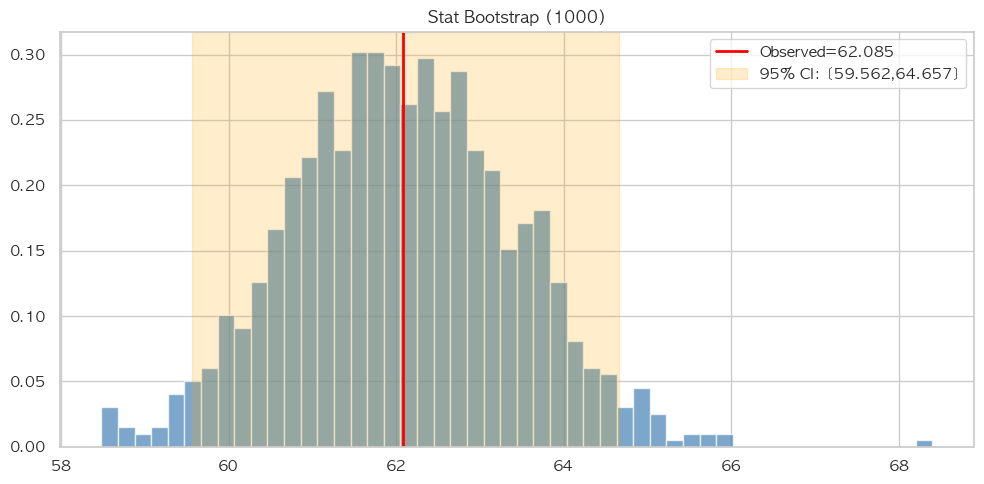

In [16]:
res = np_methods.bootstrap_ci(series, stat_func=np.mean, n_boot=1000)
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 데이터가 적을 때, 통계량(평균, 중앙값 등)의 **신뢰구간**을 추정합니다.

**📊 결과 읽는 법**:
- **신뢰구간 [하한, 상한]**: 
  - → "95% 확률로 진짜 값이 이 범위 안에 있다"
  - → 예: CI = [58.5, 65.2] → 진짜 평균은 58.5~65.2 사이
- **구간 폭**:
  - **좁은 구간**: 추정이 정확함 (데이터 많거나 일관적)
  - **넓은 구간**: 추정이 불확실함 (데이터 적거나 변동 심함)

**💬 부트스트랩이란?**:
- 기존 데이터를 **반복 재샘플링**하여 통계량 분포를 추정
- 데이터가 적을 때 매우 유용
- 정규분포 가정 불필요

**💼 실무 활용**:
- 예: 신약 임상시험 (n=15명) 평균 효과 → CI = [2.3, 5.7]
  - 판단: "진짜 효과는 2.3~5.7 사이. 모두 양수이므로 효과 있음. 추가 대규모 시험 정당화"
- 예: 소규모 설문(n=20명) 만족도 중앙값 → CI = [3.2, 8.5]
  - 판단: "구간이 매우 넓음. 추정 불확실. 표본 크기 늘려 재조사 필요"
- 예: 제품 불량률 (n=100개) → CI = [0.02, 0.08]
  - 판단: "진짜 불량률은 2~8%. 구간이 좁아 신뢰 가능. 품질 기준 설정 가능"

**📈 차트 확인**:
- **히스토그램**: 부트스트랩 분포 모양
- **수직선 2개**: 신뢰구간 하한/상한
- **구간 폭**: 선 사이 거리가 좁을수록 정확함

#### 4.2 순열 검정 (Permutation Test)


  분석 결과 요약
  observed_diff................. 21.9942
  p_value....................... 0.0000


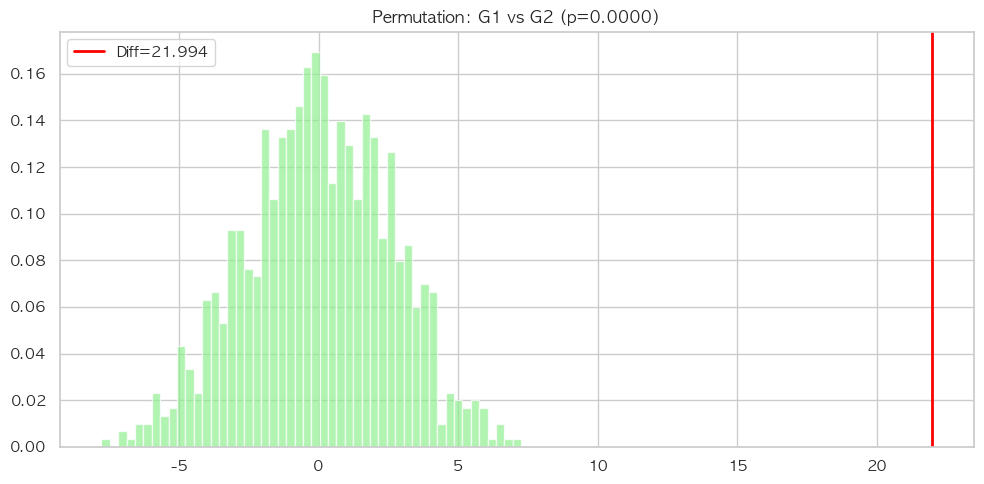

In [17]:
stat_func = np.mean  # 단일 그룹의 평균을 계산하는 함수
res = np_methods.permutation_test(group_a, group_b, stat_func=stat_func, n_perm=1000)
show_result(res)

##### 💡 결과 해석

**🎯 이 분석의 목적**: 정규분포 가정이 불가능할 때, **두 그룹의 차이가 우연인지** 검정합니다.

**📊 결과 읽는 법**:
- **p < 0.05** → 두 그룹 차이가 **진짜**입니다
  - → 우연으로 이런 차이가 나올 확률 5% 미만
  - → 그룹 A와 B는 실제로 다른 모집단
- **p ≥ 0.05** → 두 그룹 차이가 **우연**입니다
  - → 운이 나빠서 차이가 난 것일 수 있음
  - → 두 그룹을 다르다고 결론 내릴 수 없음

**💬 순열검정이란?**:
- 데이터를 **무작위로 섞어서** 관찰된 차이가 우연인지 확인
- 예: 그룹 라벨을 1000번 섞어보고, 원래 차이보다 큰 차이가 몇 번 나오는지 계산
- 정규분포, 동분산 등 **어떤 가정도 필요 없음**

**💼 실무 활용**:
- 예: 신약 vs 위약 평균 차이 = 5, p = 0.002
  - 판단: "차이가 우연이 아님. 신약이 진짜 효과 있음. 임상 시험 성공"
- 예: A/B 테스트 전환율 차이 = 2%, p = 0.35
  - 판단: "2% 차이는 우연일 수 있음. A와 B 중 어느 것이 좋다고 결론 못 내림. 샘플 더 모으거나 다른 방법 시도"
- 예: 시간대별 매출 차이 = 100만원, p = 0.01
  - 판단: "시간대별 차이가 진짜임. 피크 시간대 인력 배치 강화 필요"

**📈 차트 확인**:
- **순열 분포 히스토그램**: 우연히 나올 수 있는 차이들의 분포
- **관찰된 차이 (빨간 선)**: 실제로 관찰된 차이
- **빨간 선이 히스토그램 끝에 위치**: 매우 드문 경우 → 우연 아님 → p 값 작음